# Reinforcement Learning from Scratch Part 2: Applying Model-free Methods and Evaluating Parameters in Detail



## Introduction

The aim is to find the best action between throwing or moving to a better position in order to get paper into a bin (trash can). In this problem, we may throw from any position in the room but the probability of it is relative to the current distance from the bin and the direction in which the paper is thrown. Therefore the actions available are to throw the paper in any 360 degree direction or move to a new position to try and increase the probability that a throw made will go into the bin.

[Previously, in part 1, we introduced the problem where the bin's location is known and can be solved directly with Value-Itearation methods.](https://www.kaggle.com/osbornep/rl-from-scratch-part-1-defining-the-environment)

**In part 2, we now show how RL can be used similarly to find the optimal policy if the probabilities are hidden using model-free methods (e.g. Q-learning, Monte Carlo, etc).**

**Furthermore, a key aim of this project is to demsontrate, in detail, the effect that varying parameters within the RL model has on the output.**

I will also be publishing an accompanying article explaining the process in a simpler format that can be found on my Medium page:

https://medium.com/@sterlingosborne

## Motivation

This project was created as a means to learn Reinforcement Learning independently in a Python notebook. In other words, without the need of a complex, virtual environment to interact with. By fully defining the probabilistic environment, we are able to simplify the learning process and clearly demonstrate the effect changing parameters has on the results. This is a valuable in any Machine Learning task but particuarly in Reinforcement Learning where it can be hard to understand the impact varying parameters without a clear and well-defined example.

**Furthermore, we use this as an opportunity to introduce a novel visualisation method for examining parameters.** When we vary parameters in Reinforcemnet Learning, we observe the results over a number of attempts (or episodes) where we hope to show stability and convergence. This is a two dimensional comparison (x = episode and y = output) and when we want to observe the results if we vary a parameter this becomes three dimentional (x = episode, y = output and z = parameter). The simplest and most commonly used solution is to produce multiple plots for each parameter choice. An alternative, but more complex visual choice, is to plot in three dimensions.

**Instead, we introduce our novel method of an interactive animation whereby the parameter change is shown over time.**

The aim of this visulisation is to improve the way in which you compare parameter choices. However, because parameter selection is often a process that needs to be performed quickly, we acknowledge the requirement that this must be simple to achieve. The final parameter choices may then be formatted appropiately but the aesthetics of the visuals in the decision process may be less strict. 

Therefore, although this is a method that we have [introduced previously](https://towardsdatascience.com/creating-interactive-animation-for-parameter-optimisation-using-plot-ly-8136b2997db), we have since taken this further and formally defined as a package that can be easily downloaded and used without extensive knowledge of Plot.ly's library. 

**-----------------GITHUB RELEASE IN PROGRESS---------------------**

We will demosntrate how to use the graphing function in this notebook. A quick example of the interactive animation can be used is shown below where we can see the dimensions discussed previously.

![Interactive Animation Example](https://i.imgur.com/qrpwvCi.gif)


**Lastly, state of the art research in model explainability emphasis the requirement to digrammatically outline methods clearly and consistently.** 

[Researchers from Google](https://arxiv.org/abs/1810.03993) have introduced **Model Cards** as a means to provide transparency in training algorithms. 

*Trained machine learning models are increasingly used to perform high-impact tasks in areas such as law enforcement, medicine, education, and employment. In order to clarify the intended use cases of machine learning models and minimize their usage in contexts for which they are not well suited, we recommend that released models be accompanied by documentation detailing their performance characteristics. *

![Model Cards](https://i.imgur.com/2no3rHb.png)


Furthermore, a colleague of mine is introducing a framework for formalising diagrammatic methods for skilled researchers to share their work; known as [DIAL](https://arxiv.org/abs/1812.11142). This research attempts to indentify recurring primitives and building blocks of AI systems, and proposes a schematic notation to try and facilitate improved communication about AI Systems research.

*Currently, there is no consistent model for visually or formally representing the architecture of AI systems. This lack of representation brings interpretability, correctness and completeness challenges in the description of existing models and systems. DIAL (The Diagrammatic AI Language) has been created with the aspiration of being an "engineering schematic" for AI Systems. It is presented here as a starting point for a community dialogue towards a common diagrammatic language for AI Systems.*



**Therefore, we have created a visual that shows and summarises the entire workflow to produce the final output:**


![RL Complete Process](https://i.imgur.com/2mHMuQg.png)

## Pre-processing: Introducing the Probabilistic Environment 

Following the previously defined environment (see [META notebook](https://www.kaggle.com/osbornep/meta-environment-defined-only-for-forking)) we have also found the optimal policy calculated from value iteration.

The optimal policy can be imported from the data file and is fixed given the bin is at (0,0) and the probabilities are calculated as shown in the function below.

### RL Environment Definitions

A **policy** is the currently recommended actions for all given states. The **states ($s$ and $s'$)** are the position in the room and the **actions ($a$)** are either moving in one of 8 directions (north, north east, east, ... north west) or throwing in any 360 degree direction (0,1,2,3,4,...,359,360 degrees) from due north (see [Navigation Bearings](https://en.wikipedia.org/wiki/Bearing_(navigation)). 

In our probabilistic environment, we have defined that **moving has a guaranteed outcome** of being followed correctly (i.e. you dont miss-step) but **throwing in a direction is not guaranteed to get into the bin**. The probability of the throw successfully going into the bin is relative to the distance of the current position to the bin and the direction thrown from the true direction. 

This defines our probabilistic environment and transition function:

$$ P_{a}(s,s')=Pr(s_{t+1}=s'|s_{t}=s,a_{t}=a) $$

is the probability of transition from state $s$ to state $s'$ under action $a$ (https://en.wikipedia.org/wiki/Reinforcement_learning).

(Note: bin is an English term for trash can/ dustbin/ garbage pail/ litter basket/ trash barrel/ trash bin/ trash can/ wastebasket/ wastepaper basket)

In [1]:
import time
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
optimal_policy = pd.read_csv('../input/OptimalPolicy_angletol45.csv')
optimal_policy.head()

,Unnamed: 0,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2,u,v
0,0,-10,-10,1,none,MOVE,1,1,-1000,0.1,0.1
1,1,-10,-9,1,none,MOVE,1,1,-1000,0.1,0.1
2,2,-10,-8,1,none,MOVE,1,1,-1000,0.1,0.1
3,3,-10,-7,1,none,MOVE,1,1,-1000,0.1,0.1
4,4,-10,-6,1,none,MOVE,1,1,-1000,0.1,0.1


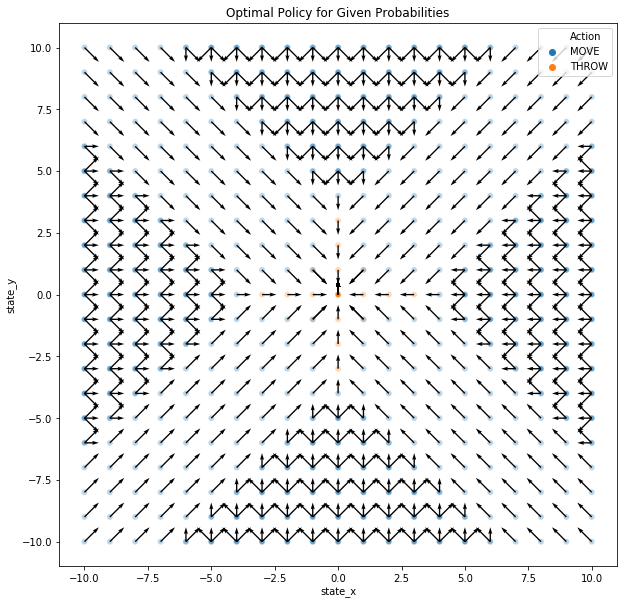

In [3]:
# Create Quiver plot showing current optimal policy in one cell
optimal_action_list = optimal_policy.copy()

x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values
plt.figure(figsize=(10, 10))
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action', alpha = 0.3)
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
plt.title("Optimal Policy for Given Probabilities")
plt.show()

### Probability Function
This function defines the probability of a sucessful throw from any given state and is calculated by the following:

First, if the position is the same as the bin (i.e. the person is directly inside the bin already) then the probability is fixed to 100%.

Next, we have to re-define the throwing direction in two cases to accomodate for the fact that 360 degrees is the same as 0 degrees. For example, if we are south-west of the bin and throw 350 degrees, this would be the same as -10 degrees and would then relate to a bearing from the person to the bin less than 90 correctly.

Then the euclidean distance is calculated followed by the max distance a person could be from the bin.

We then calculate the bearing from the person to the bin following the previous figure and calcualte the score bounded within a +/- 45 degree window. Throws that are closest to the true bearing score higher whilst those further away score less, anything more than 45 degrees (or less than -45 degrees) are negative and then set to a zero probability.

Lastly, the overall probability is related to both the distance and direction given the current position.

In [4]:
# Probability Function
def probability(bin_x, bin_y, state_x, state_y, throw_deg):


    #First throw exception rule if person is directly on top of bin:
    if((state_x==bin_x) & (state_y==bin_y)):
        probability = 1
    else:
        
        
        # To accomodate for going over the 0 degree line
        if((throw_deg>270) & (state_x<=bin_x) & (state_y<=bin_y)):
            throw_deg = throw_deg - 360
        elif((throw_deg<90) & (state_x>bin_x) & (state_y<bin_y)):
            throw_deg = 360 + throw_deg
        else:
            throw_deg = throw_deg
            
        # Calculate Euclidean distance
        distance = ((bin_x - state_x)**2 + (bin_y - state_y)**2)**0.5

        # max distance for bin will always be on of the 4 corner points:
        corner_x = [-10,-10,10,10]
        corner_y = [-10,10,-10,10]
        dist_table = pd.DataFrame()
        for corner in range(0,4):
            dist = pd.DataFrame({'distance':((bin_x - corner_x[corner])**2 + (bin_y - corner_y[corner])**2)**0.5}, index = [corner])
            dist_table = dist_table.append(dist)
        dist_table = dist_table.reset_index()
        dist_table = dist_table.sort_values('distance', ascending = False)
        max_dist = dist_table['distance'][0]
        
        distance_score = 1 - (distance/max_dist)


        # First if person is directly horizontal or vertical of bin:
        if((state_x==bin_x) & (state_y>bin_y)):
            direction = 180
        elif((state_x==bin_x) & (state_y<bin_y)):
             direction = 0
        
        elif((state_x>bin_x) & (state_y==bin_y)):
             direction = 270
        elif((state_x<bin_x) & (state_y==bin_y)):
             direction = 90
              
        # If person is north-east of bin:
        elif((state_x>bin_x) & (state_y>bin_y)):
            opp = abs(bin_x - state_x)
            adj = abs(bin_y - state_y)
            direction = 180 +  np.degrees(np.arctan(opp/adj))

        # If person is south-east of bin:
        elif((state_x>bin_x) & (state_y<bin_y)):
            opp = abs(bin_y - state_y)
            adj = abs(bin_x - state_x)
            direction = 270 +  np.degrees(np.arctan(opp/adj))

        # If person is south-west of bin:
        elif((state_x<bin_x) & (state_y<bin_y)):
            opp = abs(bin_x - state_x)
            adj = abs(bin_y - state_y)
            direction =  np.degrees(np.arctan(opp/adj))

        # If person is north-west of bin:
        elif((state_x<bin_x) & (state_y>bin_y)):
            opp = abs(bin_y - state_y)
            adj = abs(bin_x - state_x)
            direction = 90 +  np.degrees(np.arctan(opp/adj))

        direction_score = (45-abs(direction - throw_deg))/45
      
        probability = distance_score*direction_score
        if(probability>0):
            probability = probability
        else:
            probability = 0
        
    return(probability)
    

### Initialise State-Action Pairs
Before applying the algorithm, we intialise each state-action value into a table. First we formthis for all throwing actions then all moving actions.

We can throw in any direction and therefore there are 360 actions for each degree starting from north as 0 clockwise to 359 degrees.

Although movement may seem simpler in that there are 8 possible actions (north, north east, east, etc) there are complications in that unlike being able to throw in any direction from any position, there are some movements that aren't possible. For example, if we are at the edge of the room, we cannot move beyong the boundary and this needs to be accounted for. Although this could be coded nicer, I have done this manually with the if/elif statements shown that skips the row if the position and movement is not possible.

In [5]:
#Define Q(s,a) table by all possible states and THROW actions initialised to 0
Q_table = pd.DataFrame()
for z in range(0,360):
    throw_direction = int(z)
    for i in range(0,21):
        state_x = int(-10 + i)
        for j in range(0,21):
            state_y = int(-10 + j)
            reward = 0
            Q = pd.DataFrame({'throw_dir':throw_direction,'move_dir':"none",'state_x':state_x,'state_y':state_y,'Q':0, 'reward': reward}, index = [0])
            Q_table = Q_table.append(Q)
Q_table = Q_table.reset_index(drop=True)
print("Q table 1 initialised")

#Define Q(s,a) table by all possible states and MOVE actions initialised to 0

for x in range(0,21):
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        # 8 Possible move directions from [North, North-East, East, South-East, South, South-West, West, North-Wsest]
        for m in range(0,8):
            move_dir = int(m)
            
            # skip impossible moves starting with 4 corners then edges
            if((state_x==10)&(state_y==10)&(move_dir==0)):
                continue
            elif((state_x==10)&(state_y==10)&(move_dir==2)):
                continue
                
            elif((state_x==10)&(state_y==-10)&(move_dir==2)):
                continue
            elif((state_x==10)&(state_y==-10)&(move_dir==4)):
                continue
                
            elif((state_x==-10)&(state_y==-10)&(move_dir==4)):
                continue
            elif((state_x==-10)&(state_y==-10)&(move_dir==6)):
                continue
                
            elif((state_x==-10)&(state_y==10)&(move_dir==6)):
                continue
            elif((state_x==-10)&(state_y==10)&(move_dir==0)):
                continue
                
            elif((state_x==10) & (move_dir == 1)):
                continue
            elif((state_x==10) & (move_dir == 2)):
                continue
            elif((state_x==10) & (move_dir == 3)):
                continue
                 
            elif((state_x==-10) & (move_dir == 5)):
                continue
            elif((state_x==-10) & (move_dir == 6)):
                continue
            elif((state_x==-10) & (move_dir == 7)):
                continue
                 
            elif((state_y==10) & (move_dir == 1)):
                continue
            elif((state_y==10) & (move_dir == 0)):
                continue
            elif((state_y==10) & (move_dir == 7)):
                continue
                 
            elif((state_y==-10) & (move_dir == 3)):
                continue
            elif((state_y==-10) & (move_dir == 4)):
                continue
            elif((state_y==-10) & (move_dir == 5)):
                continue
                 
            else:
                reward = 0
                Q = pd.DataFrame({'throw_dir':"none",'move_dir':move_dir,'state_x':state_x,'state_y':state_y,'Q':0, 'reward': reward}, index = [0])
                Q_table = Q_table.append(Q)
Q_table = Q_table.reset_index(drop=True)
print("Q table 2 initialised")
Q_table.tail()

Q table 1 initialised
Q table 2 initialised


,throw_dir,move_dir,state_x,state_y,Q,reward
162035,none,6,10,9,0,0
162036,none,7,10,9,0,0
162037,none,4,10,10,0,0
162038,none,5,10,10,0,0
162039,none,6,10,10,0,0


In [6]:
# Initialise V values for all state-action pairs
Q_table['V'] = 0

In [7]:
# Calculate Probability of each State-Action pair, 1 for movement else use probability function
bin_x = 0
bin_y = 0

prob_list = pd.DataFrame()
for n,action in enumerate(Q_table['throw_dir']):
    # Guarantee 100% probability if movement
    if(action == "none"):
        prob = 1
    # Calculate if thrown
    else:
        prob = probability(bin_x, bin_y, Q_table['state_x'][n], Q_table['state_y'][n], action)
    prob_list = prob_list.append(pd.DataFrame({'prob':prob}, index = [n] ))
prob_list = prob_list.reset_index(drop=True)
Q_table['prob'] = prob_list['prob']

In [8]:
Q_table.head()

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,0,none,-10,-10,0,0,0,0.0
1,0,none,-10,-9,0,0,0,0.0
2,0,none,-10,-8,0,0,0,0.0
3,0,none,-10,-7,0,0,0,0.0
4,0,none,-10,-6,0,0,0,0.0


---

# Defining Model-free Reinforcement Learning Methods

We introduce three model-free methods that are considered to be the simplest to apply and compare their strengths and weaknesses. However, before we do this we consider the difference between model-free methods and our previously used value-iteration model-based method. In short, model-based methods use the knowledge of the probabilistic environment as a guide and plans the best actions accordingly. In model-free methods, the algorithm has no knowledge of this probabilities it just tries actions and observes the results.

In this example, we have calculated the proabiblities and will use these to find the outcome of the actions but they are not used within the algorithm's learning directly. 

Furthmore, in the model-based methods, we update all actions in large "sweeps" where the value of all states are updated in one pass. In model-free methods we use eipsodes where only states that are visited are updated. An **episode** is a path from a start state to the terminal state; in our example, the terminal state is when the algorithm throws the papers and the outcome may be successful or a miss. 

![Model Update Differences](https://i.imgur.com/vgE21Wg.png)




## Forming Episodes and Defining the Action Selection Process

If we define the starting position, an episode is the actions taken from that position until the paper is thrown. If it reaches the bin, then we have a positive goal reward of +1. However, if we miss the bin, then we have a negative goal reward of -1.

We can form the episodes randomly:

In [9]:
# Define start position
start_x = -5
start_y = -5

In [10]:
# Subset the Q table for just this start state and randomly select an action
Q_table[ (Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['move_dir']!="none") ].sample()

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
159551,none,5,-5,-5,0,0,0,1.0


And we can continue this for multiple actions until the paper is thrown

In [11]:
a_1 = Q_table[ (Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['move_dir']!="none") ].sample()


move_direction = a_1['move_dir'].iloc[0]
#Map this to actual direction and find V(s) for next state
if(move_direction == 0):
    move_x = 0
    move_y = 1
elif(move_direction == 1):
    move_x = 1
    move_y = 1
elif(move_direction == 2):
    move_x = 1
    move_y = 0
elif(move_direction == 3):
    move_x = 1
    move_y = -1
elif(move_direction == 4):
    move_x = 0
    move_y = -1
elif(move_direction == 5):
    move_x = -1
    move_y = -1
elif(move_direction == 6):
    move_x = -1
    move_y = 0
elif(move_direction == 7):
    move_x = -1
    move_y = 1

new_x = a_1['state_x'].iloc[0]+move_x
new_y = a_1['state_y'].iloc[0]+move_y
    
a_2 = Q_table[ (Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['move_dir']!="none") ].sample()
a_2

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
159382,none,6,-6,-6,0,0,0,1.0


### Action Selection
We could continue this selection process but this is a highly inefficient method of choosing which action to take. When we implement our learning process we will begin to learn which actions lead towards the positive goal so if we keep randomly selecting we are wasting all that effort.

Therefore, we instead introduce a method that takes this into account, known as **epsilon-greedy**.

*The best lever is selected for a proportion $1-\epsilon$ of the trials, and a lever is selected at random (with uniform probability) for a proportion $\epsilon$ . A typical parameter value might be $epsilon =0.1$, but this can vary widely depending on circumstances and predilections.* ([wiki](https://en.wikipedia.org/wiki/Multi-armed_bandit))

In other words, we pick an action randomly with probability $\epsilon$ and will otherwise pick the best action. If we have mutliple "best actions" we then randomly select from this list.

So why do we not simply keep picking the best action each time? Well this can cause a problem if we have an action that works but is not neccessarily the best. This is often considered in other Machine Learning problems as the local minimum/maxmum. If we keep using an action that seems to work we may miss the opportunity to try a better action because we never tried it and this can cause instability in the results. 

The animation below demonstrates the outcome as we reduce epsilon. With high epsilon values, we are randomly selecting actions so will likely pick bad ones. As we reduce epsilon we select actions more and more greedily improving the results whilst still ensuring we can explore new actions to minimise the risk we are in a local max ratherh than global max.

**We therefore select a small epislon value $\epsilon = 0.1$**

![epsilon varied](https://i.imgur.com/Rx7HVAE.gif)

There are other methods that can be considered, such as the [Softmax Function](https://en.wikipedia.org/wiki/Softmax_function).

#### Action Cap
We also introduce an **action cap** which stops the episode occuring endlessly. If we reach this cap then we can consider the episode goal as negative but set it very large so is unlikely to reach it.

#### Action Selection between throw and move
Because we have many more throwing actions than moving action (360 vs 8), as before, we introduce the notion that have a 50/50 chance of being a throw or move action first and then subsequently select from these sub-choices. 

#### Code Format
Just to make things easier to track, we introduce a method that creates a data table with the output actions and will continue to use this for all methods. [Information on this can be found in this post](https://towardsdatascience.com/3-tips-to-improving-your-data-science-workflow-71a6fb8e6f19).

**Completely Random Action Selection**

In [12]:
# Define start position
start_x = -5
start_y = -5
action_cap = 100

action_table = pd.DataFrame()
for a in range(0,action_cap):
    
    # Introduce 50/50 chance for move or throw action
    rng = np.random.rand()
    if rng<=0.5:
        action_class = "throw"
    else:
        action_class = "move"
    
    # THROW ACTION
    if action_class == "throw":
        # If first action, use start state
        if a==0:
            action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']!="none")].sample()
        # Else new x and y are from previous itneration's output
        else:
            new_x = action['state_x'].iloc[0]
            new_y = action['state_y'].iloc[0]
            action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']!="none")].sample()
    
    # ELSE MOVE ACTION
    else:
        # If first action, use start state
        if a==0:
            action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']=="none")].sample()
        # Else new x and y are from previous itneration's output
        else:
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']=="none")].sample()
            
    action_table = action_table.append(action)
   
    # Break loop if action is a throw
    if action['throw_dir'].iloc[0]!="none":
        break
    else:
        continue
action_table = action_table.reset_index(drop=True)     
action_table.head()
    
    

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,none,2,-5,-5,0,0,0,1.0
1,none,2,-4,-5,0,0,0,1.0
2,245,none,-4,-5,0,0,0,0.0


**$\epsilon-greedy$ Action Selection**

In [13]:
# Define start position
start_x = -5
start_y = -5
action_cap = 100

epsilon = 0.1

action_table = pd.DataFrame()
for a in range(0,action_cap):
    
    
    rng_epsilon = np.random.rand()

    # If our rng is less than or equal to the epsilon parameter, we randomly select
    if rng_epsilon<=epsilon:
        # Introduce 50/50 chance for move or throw action
        rng = np.random.rand()
        if rng<=0.5:
            action_class = "throw"
        else:
            action_class = "move"

        # THROW ACTION
        if action_class == "throw":
            # If first action, use start state
            if a==0:
                action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']!="none")].sample()
            # Else new x and y are from previous itneration's output
            else:
                new_x = action['state_x'].iloc[0]
                new_y = action['state_y'].iloc[0]
                action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']!="none")].sample()

        # ELSE MOVE ACTION
        else:
            # If first action, use start state
            if a==0:
                action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']=="none")].sample()
            # Else new x and y are from previous itneration's output
            else:
                move_direction = action['move_dir'].iloc[0]
                #Map this to actual direction and find V(s) for next state
                if(move_direction == 0):
                    move_x = 0
                    move_y = 1
                elif(move_direction == 1):
                    move_x = 1
                    move_y = 1
                elif(move_direction == 2):
                    move_x = 1
                    move_y = 0
                elif(move_direction == 3):
                    move_x = 1
                    move_y = -1
                elif(move_direction == 4):
                    move_x = 0
                    move_y = -1
                elif(move_direction == 5):
                    move_x = -1
                    move_y = -1
                elif(move_direction == 6):
                    move_x = -1
                    move_y = 0
                elif(move_direction == 7):
                    move_x = -1
                    move_y = 1

                new_x = action['state_x'].iloc[0]+move_x
                new_y = action['state_y'].iloc[0]+move_y
                action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']=="none")].sample()

    #  If our rng is more than the epsilon parameter, we select the best action ("greedily")
    else:
        # Sort by V, use previous action if not first in episode
        if a==0:
            sorted_actions = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y)].sort_values('V', ascending = False)
        else:
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            sorted_actions = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y)].sort_values('V', ascending = False)
            
        best_action = sorted_actions[sorted_actions['V'] == sorted_actions['V'].iloc[0]]

        # If we only have one best action, simply pick this
        if len(best_action)==1:
            action = sorted_actions.iloc[0]
            
        # Otherwise, if we have multiple "best" actions, we randomly select from these "best" actions
        else:
            rng = np.random.rand()
            if rng<=0.5:
                action_class = "throw"
            else:
                action_class = "move"
            # THROW ACTION
            if action_class == "throw":
                action = best_action[(best_action['throw_dir']!="none")].sample()
            # ELSE MOVE ACTION
            else:
                action = best_action[(best_action['throw_dir']=="none")].sample()
    
    action_table = action_table.append(action)
   
    # Break loop if action is a throw
    if action['throw_dir'].iloc[0]!="none":
        break
    else:
        continue
action_table = action_table.reset_index(drop=True)     
action_table.head()
    
    

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,none,2,-5,-5,0,0,0,1.0
1,none,5,-4,-5,0,0,0,1.0
2,295,none,-5,-6,0,0,0,0.0


**$\epsilon-greedy$ as a Function **

To make things easier later, we define this now as a function so that our code later on is simpler and we can focus on the algorithm. 

In [14]:
def eps_greedy_V(Q_table, epsilon, start_x, start_y, action_num, action):
    a = action_num
    rng_epsilon = np.random.rand()

    # If our rng is less than or equal to the epsilon parameter, we randomly select
    if rng_epsilon<=epsilon:
        # Introduce 50/50 chance for move or throw action
        rng = np.random.rand()
        if rng<=0.5:
            action_class = "throw"
        else:
            action_class = "move"

        # THROW ACTION
        if action_class == "throw":
            # If first action, use start state
            if a==0:
                action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']!="none")].sample()
            # Else new x and y are from previous itneration's output
            else:
                new_x = action['state_x'].iloc[0]
                new_y = action['state_y'].iloc[0]
                action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']!="none")].sample()

        # ELSE MOVE ACTION
        else:
            # If first action, use start state
            if a==0:
                action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']=="none")].sample()
            # Else new x and y are from previous itneration's output
            else:
                move_direction = action['move_dir'].iloc[0]
                #Map this to actual direction and find V(s) for next state
                if(move_direction == 0):
                    move_x = 0
                    move_y = 1
                elif(move_direction == 1):
                    move_x = 1
                    move_y = 1
                elif(move_direction == 2):
                    move_x = 1
                    move_y = 0
                elif(move_direction == 3):
                    move_x = 1
                    move_y = -1
                elif(move_direction == 4):
                    move_x = 0
                    move_y = -1
                elif(move_direction == 5):
                    move_x = -1
                    move_y = -1
                elif(move_direction == 6):
                    move_x = -1
                    move_y = 0
                elif(move_direction == 7):
                    move_x = -1
                    move_y = 1

                new_x = action['state_x'].iloc[0]+move_x
                new_y = action['state_y'].iloc[0]+move_y
                action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']=="none")].sample()

    #  If our rng is more than the epsilon parameter, we select the best action ("greedily")
    else:
        # Sort by V, use previous action if not first in episode
        if a==0:
            sorted_actions = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y)].sort_values('V', ascending = False)
        else:
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            sorted_actions = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y)].sort_values('V', ascending = False)
            
        best_action = sorted_actions[sorted_actions['V'] == sorted_actions['V'].iloc[0]]

        # If we only have one best action, simply pick this
        if len(best_action)==1:
            action = best_action
            
        # Otherwise, if we have multiple "best" actions, we randomly select from these "best" actions
        else:
            rng = np.random.rand()
            if rng<=0.5:
                action_class = "throw"
            else:
                action_class = "move"
            # THROW ACTION
            if action_class == "throw":
                #Add excemption if no throw directions in "best" actions
                if len(best_action[(best_action['throw_dir']!="none")])>0:
                    action = best_action[(best_action['throw_dir']!="none")].sample()
                else:
                    action = best_action[(best_action['throw_dir']=="none")].sample()
            # ELSE MOVE ACTION
            else:
                action = best_action[(best_action['throw_dir']=="none")].sample()

    return(action)



In [15]:
def eps_greedy_Q(Q_table, epsilon, start_x, start_y, action_num, action):
    a = action_num
    rng_epsilon = np.random.rand()

    # If our rng is less than or equal to the epsilon parameter, we randomly select
    if rng_epsilon<=epsilon:
        # Introduce 50/50 chance for move or throw action
        rng = np.random.rand()
        if rng<=0.5:
            action_class = "throw"
        else:
            action_class = "move"

        # THROW ACTION
        if action_class == "throw":
            # If first action, use start state
            if a==0:
                action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']!="none")].sample()
            # Else new x and y are from previous itneration's output
            else:
                new_x = action['state_x'].iloc[0]
                new_y = action['state_y'].iloc[0]
                action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']!="none")].sample()

        # ELSE MOVE ACTION
        else:
            # If first action, use start state
            if a==0:
                action = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y) & (Q_table['throw_dir']=="none")].sample()
            # Else new x and y are from previous itneration's output
            else:
                move_direction = action['move_dir'].iloc[0]
                #Map this to actual direction and find V(s) for next state
                if(move_direction == 0):
                    move_x = 0
                    move_y = 1
                elif(move_direction == 1):
                    move_x = 1
                    move_y = 1
                elif(move_direction == 2):
                    move_x = 1
                    move_y = 0
                elif(move_direction == 3):
                    move_x = 1
                    move_y = -1
                elif(move_direction == 4):
                    move_x = 0
                    move_y = -1
                elif(move_direction == 5):
                    move_x = -1
                    move_y = -1
                elif(move_direction == 6):
                    move_x = -1
                    move_y = 0
                elif(move_direction == 7):
                    move_x = -1
                    move_y = 1

                new_x = action['state_x'].iloc[0]+move_x
                new_y = action['state_y'].iloc[0]+move_y
                action = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y) & (Q_table['throw_dir']=="none")].sample()

    #  If our rng is more than the epsilon parameter, we select the best action ("greedily")
    else:
        # Sort by V, use previous action if not first in episode
        if a==0:
            sorted_actions = Q_table[(Q_table['state_x']==start_x) &  (Q_table['state_y']==start_y)].sort_values('Q', ascending = False)
        else:
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            sorted_actions = Q_table[(Q_table['state_x']==new_x) &  (Q_table['state_y']==new_y)].sort_values('Q', ascending = False)
            
        best_action = sorted_actions[sorted_actions['Q'] == sorted_actions['Q'].iloc[0]]

        # If we only have one best action, simply pick this
        if len(best_action)==1:
            action = pd.DataFrame(best_action)
            
        # Otherwise, if we have multiple "best" actions, we randomly select from these "best" actions
        else:
            rng = np.random.rand()
            if rng<=0.5:
                action_class = "throw"
            else:
                action_class = "move"
            # THROW ACTION
            if action_class == "throw":
                #Add excemption if no throw directions in "best" actions
                if len(best_action[(best_action['throw_dir']!="none")])>0:
                    action = best_action[(best_action['throw_dir']!="none")].sample()
                else:
                    action = best_action[(best_action['throw_dir']=="none")].sample()
            # ELSE MOVE ACTION
            else:
                action = best_action[(best_action['throw_dir']=="none")].sample()
    

    return(action)



In [16]:
# Define start position
start_x = -5
start_y = -5
action_cap = 100

epsilon = 0.1

action_table = pd.DataFrame()
action = None
for a in range(0,action_cap):
    
    action = eps_greedy_V(Q_table, epsilon, start_x, start_y, a, action)
    
    action_table = action_table.append(action)
   
    # Break loop if action is a throw
    if action['throw_dir'].iloc[0]!="none":
        break
    else:
        continue
action_table = action_table.reset_index(drop=True)     
action_table.head()
    
    
    
    

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,none,0,-5,-5,0,0,0,1.0
1,none,3,-5,-4,0,0,0,1.0
2,347,none,-4,-5,0,0,0,0.0


## Introducing RL Algorithms

So we have introduced episodes and how to choose actions but we have yet to demonstrate how and algorithm uses this to learn the best actions. Therefore, we will formally define our first RL algorithm, **Temporal Difference 0*.

#### Temporal Difference 0

Temporal Difference $\lambda$ are a family of algorithms depending on the choice of $\lambda$. The simplest is to set this to zero at which point have the following update rule:

**Definition: TD(0) Update Rule:** [Wiki](https://en.wikipedia.org/wiki/Temporal_difference_learning)
\begin{equation}
V(s)\leftarrow V(s)+\alpha (\overbrace {r+\gamma V(s')} ^{\text{The TD target}}-V(s))
\end{equation}

where:

- $V(s)$ is the value of state $s$, 
- $\alpha$ is the **learning rate parameter**, 
- $r$ is the reward,
- $\gamma$ is the **discount factor parameter** and, 
- $V(s')$ is the vale of the next state.

So what does this equation mean? In short, we update our knowledge of the quality of the current state, denoted $V(s)$, based on a combination of what its value is and the result of taking the action to the next state defined in the episode. 

For example, say we start the learning processing and our first action is to throw from state [-5,-5] and it successfully hits the bin, then we have a positive reward of $+1$ for reaching to goal. Therefore, we have the following update:

\begin{equation}
V_1([-5,-5])\leftarrow V_0([-5,-5])+\alpha (\overbrace { +1 +\gamma V_0([bin])} ^{\text{The TD target}}-V_0([-5,-5]))
\end{equation}

and say, just for now, we set $\alpha = 0.5 $ and $\gamma = 0.5$ and $V([bin]) = 0$ by definition, then we have:

\begin{equation}
V_1([-5,-5])\leftarrow 0+0.5 ( +1 + 0.5*0 - 0) = 0.5
\end{equation}

This may seem like a trivial calulation but it is important to remember that success is not guaranteed. Therefore, if we think about all possible actions, the result of this first throw means we believe that this throw action is current the best choice. This throw action has a value of 0.5 compared to 0 for all other actions that haven't been tested yet.

Therefore, under the $\epsilon-greedy$ selection process, we would try this again. However this time, the paper does not go in the bin but misses and we therefore have a negative terminal reward of $-1$:

\begin{equation}
V_2([-5,-5])\leftarrow V_1([-5,-5])+\alpha (\overbrace { -1 +\gamma V_1([bin])} ^{\text{The TD target}}-V_1([-5,-5]))
\end{equation}

and with the values:

\begin{equation}
V_2([-5,-5])\leftarrow 0.5+0.5 ( +1 + 0.5*0 - 0.5) = 0.5-0.25 = 0.25
\end{equation}

So we see that our value of this state has now reduced slightly to account for the second throw. 

**The core concept in Reinforcement Learning is that we are testing actions by repeated sampling; we need to repeat the number of samples until the results converge to an estimate of the true probabilistic outcomes.** 

For example, if we consider tossing a coin 2 times, we are fairly like to have both outcomes being heads but if we throw it 100 times then we would likely see a 50/50 split between heads and tails. In our example, if throwing from state [-5,-5] is a good action, then repeatedly trying this should, overall, lead to a positive result. This can be quite difficult to comprehend at first but in simple terms, we are testing the action by trial and error and making our algorithm do all the work so we don't have to.

**Note: For now, we will fix the parameters to be $\epsilon = 0.1$,  $\alpha = 0.5 $ and $\gamma = 0.5$ until we demonstrate parameter changes later.**


**Introduce Update Policy for TD(0) to Actions**

In [17]:
# Define start position
start_x = -5
start_y = -5
action_cap = 100

epsilon = 0.1
alpha = 0.5
gamma = 0.5
V_bin = 0


# Make a copy of the initalised Q table so we don't override this
Q_table_TD = Q_table.copy()

action_table = pd.DataFrame()
action = None
for a in range(0,action_cap):
    
    action = eps_greedy_V(Q_table_TD, epsilon, start_x, start_y, a, action)
    # If action is to throw, use probability to find whether this was successful or not and update accordingly
    if action['throw_dir'].iloc[0]!="none":
        rng_throw = np.random.rand()
        
        if rng_throw <= action['prob'].iloc[0]:
            reward = 1
        else:
            reward = -1
        New_V = action['V'].iloc[0] + alpha*(reward + (gamma* V_bin) - action['V'].iloc[0])
    # If move action, we have guaranteed probability and currently no reward for this
    else:
        New_V = action['V'].iloc[0]
    #Update V value for state based on outcome
    Q_table_TD['V'] = np.where( ((Q_table_TD['state_x'] == action['state_x'].iloc[0]) & 
                                (Q_table_TD['state_y'] == action['state_y'].iloc[0])),New_V, Q_table_TD['V'])
    
    
    action_table = action_table.append(action)
   
    # Break loop if action is a throw
    if action['throw_dir'].iloc[0]!="none":
        break
    else:
        continue
action_table = action_table.reset_index(drop=True)     
action_table.head()
    
    
    
    

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,191,none,-5,-5,0,0,0,0.0


In [18]:
Q_table_TD.sort_values('V',ascending=False).drop_duplicates(['state_x', 'state_y', 'Q', 'reward','V']).head()

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,0,none,-10,-10,0,0,0.0,0.0
107968,244,none,7,-3,0,0,0.0,0.0
107961,244,none,7,-10,0,0,0.0,0.0
107962,244,none,7,-9,0,0,0.0,0.0
107963,244,none,7,-8,0,0,0.0,0.0


**Repeat for a number of episodes and collect results**

In [19]:
# Define start position
start_x = -5
start_y = -5
action_cap = 10000

epsilon = 0.1
alpha = 0.5
gamma = 0.5
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_TD = Q_table.copy()

action_table = pd.DataFrame()
best_states_table = pd.DataFrame()
for e in range(0,num_episodes):
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_V(Q_table_TD, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            New_V = action['V'].iloc[0] + alpha*(reward + (gamma* V_bin) - action['V'].iloc[0])
        # If move action, we have guaranteed probability and currently no reward for this
        else:
            New_V = action['V'].iloc[0]
        #Update V value for state based on outcome
        Q_table_TD['V'] = np.where( ((Q_table_TD['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_TD['state_y'] == action['state_y'].iloc[0])),New_V, Q_table_TD['V'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_states = Q_table_TD[Q_table_TD['V']!=0].sort_values('V', ascending=False).drop_duplicates(['state_x', 'state_y', 'Q', 'reward','V'])
    best_states['episode'] = e
    
    best_states_table = best_states_table.append(best_states)
best_states_table = best_states_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_value = best_states_table[(best_states_table['state_x']==start_x) & (best_states_table['state_y']==start_y)][['episode','V']].sort_values('episode')
                                         
state_values = Q_table_TD.drop_duplicates(['state_x','state_y'])
    
    

In [20]:
best_states_table.head(10)

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob,episode
0,0,none,-5,-5,0,0,-0.50000,0.0,0
1,0,none,-5,-5,0,0,-0.75000,0.0,1
2,0,none,-5,-5,0,0,-0.87500,0.0,2
3,0,none,-6,-6,0,0,-0.50000,0.0,3
4,292,none,-5,-5,0,0,-0.87500,0.0,3
5,0,none,-6,-6,0,0,-0.50000,0.0,4
6,292,none,-5,-5,0,0,-0.93750,0.0,4
7,none,7,-5,-5,0,0,0.03125,1.0,5
8,353,none,-6,-6,0,0,-0.50000,0.0,5
9,none,7,-5,-5,0,0,0.03125,1.0,6


In [21]:
best_states_table.tail(10)

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob,episode
1343,50,none,-4,-6,0,0,-0.750000,0.312465,99
1344,49,none,-3,-7,0,0,-0.750000,0.196885,99
1345,51,none,-6,-7,0,0,-0.750000,0.267645,99
1346,75,none,-4,-7,0,0,-0.750000,0.000000,99
1347,35,none,-5,-6,0,0,-0.875000,0.399918,99
1348,148,none,-5,-4,0,0,-0.875000,0.000000,99
1349,37,none,-6,-5,0,0,-0.875000,0.316453,99
1350,79,none,-6,-4,0,0,-0.937500,0.242979,99
1351,351,none,-6,-6,0,0,-0.992188,0.000000,99
1352,333,none,-5,-5,0,0,-1.000000,0.000000,99


In [22]:
start_state_value.head()

,episode,V
0,0,-0.5000
1,1,-0.7500
2,2,-0.8750
4,3,-0.8750
6,4,-0.9375


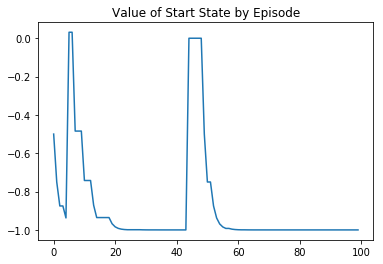

In [23]:
plt.plot(start_state_value['episode'], start_state_value['V'])
plt.title("Value of Start State by Episode")
plt.show()

In [24]:
state_values.head()

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,0,none,-10,-10,0,0,0.0,0.0
1,0,none,-10,-9,0,0,0.0,0.0
2,0,none,-10,-8,0,0,0.0,0.0
3,0,none,-10,-7,0,0,0.0,0.0
4,0,none,-10,-6,0,0,0.0,0.0


In [25]:
state_values[["state_y", "state_x", "V"]].pivot("state_y", "state_x", "V")

state_x,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10
state_y,,,,,,,,,,,,,,,,,,,,,
-10,0.0,0.0,0.0,0.0,0.000000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9,0.0,0.0,0.0,0.0,0.000000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8,0.0,0.0,0.0,0.0,0.000000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7,0.0,0.0,0.0,0.0,-0.750000,0.000,-0.750,-0.75,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6,0.0,0.0,0.0,0.5,-0.992188,-0.875,-0.750,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-5,0.0,0.0,0.0,0.0,-0.875000,-1.000,-0.375,0.00,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4,-0.5,0.0,0.0,0.0,-0.937500,-0.875,-0.500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3,0.0,0.0,0.0,0.0,-0.500000,0.000,0.500,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2,0.0,0.0,0.0,0.0,0.000000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**After 100 episodes, we see that the states around our fixed start point have updated but if we compare the following heatmap side by side with the previous line plot, we see that this has not fully converged after 100 episodes and is still updating.**

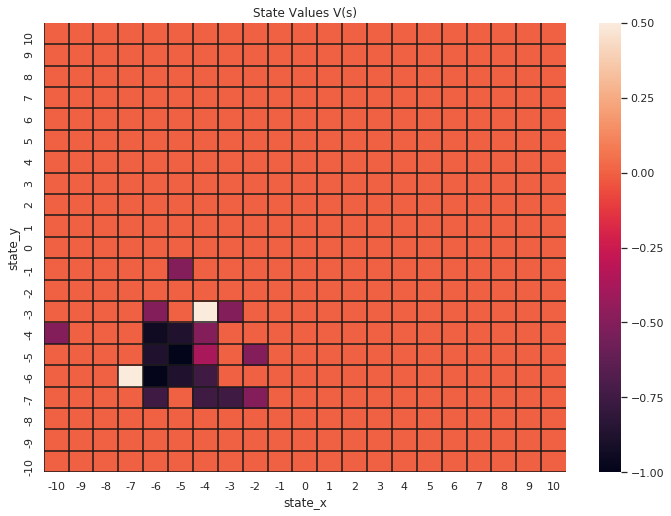

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
pivot = state_values[["state_y", "state_x", "V"]].pivot("state_y", "state_x", "V")

ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())

plt.title("State Values V(s)")
ax.invert_yaxis()

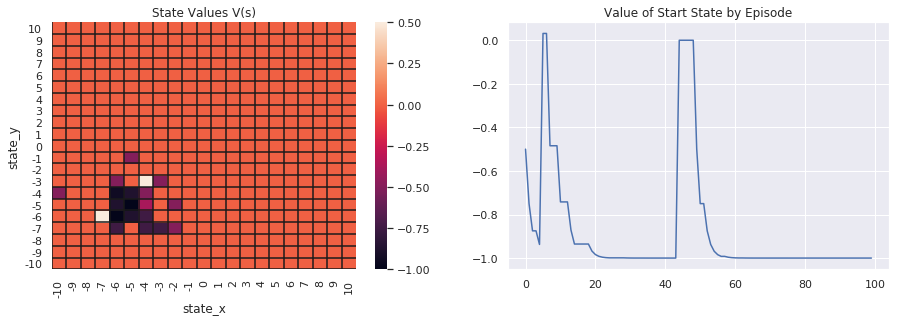

In [27]:
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_values[["state_y", "state_x", "V"]].pivot("state_y", "state_x", "V")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("State Values V(s)")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_value['episode'], start_state_value['V'])
ax2.set_title("Value of Start State by Episode")

plt.show()


**We therefore increase the number of episodes greatly from 100 to 1,000**

As we are starting to find that this takes longer and longer, a good idea is to introduce a method to keep track of the progress of the loop. [To do this, I will apply a method introduced in this post](https://towardsdatascience.com/3-tips-to-improving-your-data-science-workflow-71a6fb8e6f19).

Current Episode:  99.9 %


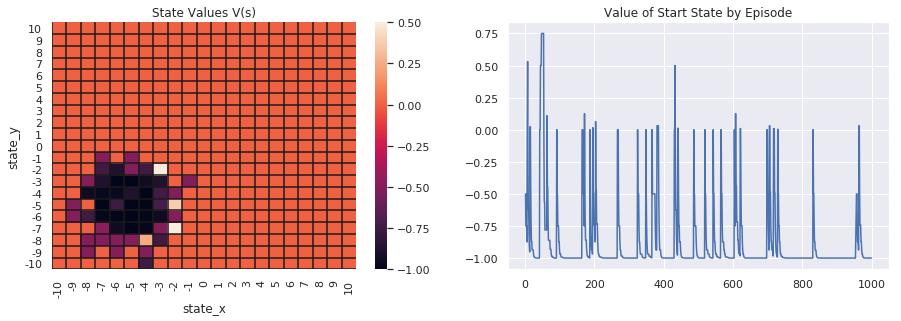

In [28]:
# Define start position
start_x = -5
start_y = -5
action_cap = 10000

epsilon = 0.1
alpha = 0.5
gamma = 0.5
V_bin = 0

num_episodes = 1000

# Make a copy of the initalised Q table so we don't override this
Q_table_TD = Q_table.copy()

action_table = pd.DataFrame()
best_states_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_V(Q_table_TD, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            New_V = action['V'].iloc[0] + alpha*(reward + (gamma* V_bin) - action['V'].iloc[0])
        # If move action, we have guaranteed probability and currently no reward for this
        else:
            New_V = action['V'].iloc[0]
        #Update V value for state based on outcome
        Q_table_TD['V'] = np.where( ((Q_table_TD['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_TD['state_y'] == action['state_y'].iloc[0])),New_V, Q_table_TD['V'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_states = Q_table_TD[Q_table_TD['V']!=0].sort_values('V', ascending=False).drop_duplicates(['state_x', 'state_y', 'Q', 'reward','V'])
    best_states['episode'] = e
    
    best_states_table = best_states_table.append(best_states)
best_states_table = best_states_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_value = best_states_table[(best_states_table['state_x']==start_x) & (best_states_table['state_y']==start_y)][['episode','V']].sort_values('episode')
                                         
state_values = Q_table_TD.drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_values[["state_y", "state_x", "V"]].pivot("state_y", "state_x", "V")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("State Values V(s)")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_value['episode'], start_state_value['V'])
ax2.set_title("Value of Start State by Episode")

plt.show()


    

**Varying Rewards**

We note that the results of this show that the value of the states are very negative and that they are diverging (i.e. not stable). 

There are a few steps we can take to improve this, first we will introduce rewards for other actions. Currently the only rewards we have are for when the algorithm throws and recieves a $+1$ for the positive goal or a $-1$ for the negative goal.

This is part of the process in Reinforcement Learning that gives us control as to what the algorithm optimises for. For example, say we want to discourage the algorithm from throwing, we could introduce a small positive reward (say 0.1) for each move action as shown below.



Current Episode:  99.9 %


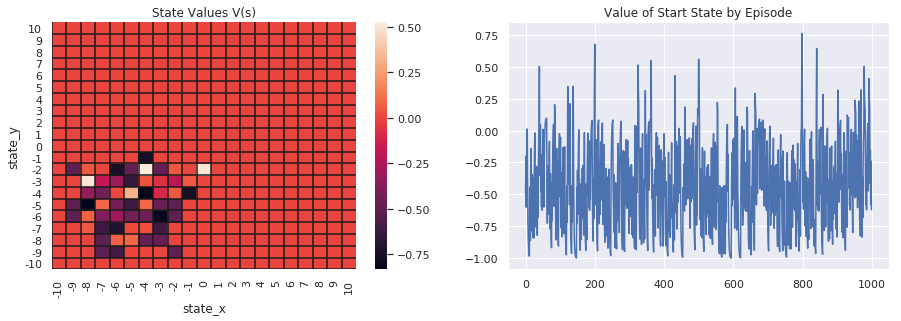

In [29]:
# Define start position
start_x = -5
start_y = -5
action_cap = 10000

epsilon = 0.1
alpha = 0.5
gamma = 0.5
V_bin = 0

num_episodes = 1000

# Make a copy of the initalised Q table so we don't override this
Q_table_TD = Q_table.copy()

action_table = pd.DataFrame()
best_states_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_V(Q_table_TD, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            New_V = action['V'].iloc[0] + alpha*(reward + (gamma* V_bin) - action['V'].iloc[0])
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            New_V = action['V'].iloc[0] + alpha*(reward + (gamma* V_bin) - action['V'].iloc[0])
        #Update V value for state based on outcome
        Q_table_TD['V'] = np.where( ((Q_table_TD['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_TD['state_y'] == action['state_y'].iloc[0])),New_V, Q_table_TD['V'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_states = Q_table_TD[Q_table_TD['V']!=0].sort_values('V', ascending=False).drop_duplicates(['state_x', 'state_y', 'Q', 'reward','V'])
    best_states['episode'] = e
    
    best_states_table = best_states_table.append(best_states)
best_states_table = best_states_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_value = best_states_table[(best_states_table['state_x']==start_x) & (best_states_table['state_y']==start_y)][['episode','V']].sort_values('episode')
                                         
state_values = Q_table_TD.drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_values[["state_y", "state_x", "V"]].pivot("state_y", "state_x", "V")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("State Values V(s)")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_value['episode'], start_state_value['V'])
ax2.set_title("Value of Start State by Episode")

plt.show()


    

**Although this appears worse at first, the value of the state oscillating shows that there is a value its trying to find but our choice of parameters is causing it to diverge. But, we at least can see that it is getting closer to converging.**

We could start varying parameters but part of the issue is that we are summarising the value of the state for a large number of actions (360 throw directions and 8 move directions). Therefore, instead of summarising this into one value, it would be better to consider the quality of each state-action pair individually.

To do this, we can introduce our second model-free method: **Q-learning**.


## Q-Learning

Much like TD(0), Q-learning learns as we take each action but instead searches through the possible subsequent actions to learn faster. 



**Definition: Q-Learning Update Rule:** [Wiki](https://en.wikipedia.org/wiki/Q-learning)
\begin{equation}
 Q^{new}(s_{t},a_{t})\leftarrow (1-\alpha )\cdot \underbrace {Q(s_{t},a_{t})} _{\text{old value}}+\underbrace {\alpha } _{\text{learning rate}}\cdot \overbrace {{\bigg (}\underbrace {r_{t}} _{\text{reward}}+\underbrace {\gamma } _{\text{discount factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\text{estimate of optimal future value}}{\bigg )}} ^{\text{learned value}}
 \end{equation}

where:

- $Q(s_t,a_t)$ is the value of state-action pair $s$, 
- $\alpha$ is the **learning rate parameter**, 
- $r$ is the reward,
- $\gamma$ is the **discount factor parameter** and, 
- $Q(s_{t+1}, a )$ is the value of action-pairs in the next state.

As before, we will fix the parameters to be $\epsilon = 0.1$,  $\alpha = 0.5 $ and $\gamma = 0.5$ 

In [30]:
# Define start position
start_x = -5
start_y = -5
bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.5
gamma = 0.5
V_bin = 0

num_episodes = 1000

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==start_x) & (best_actions_table['state_y']==start_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    

Current Episode:  99.9 %


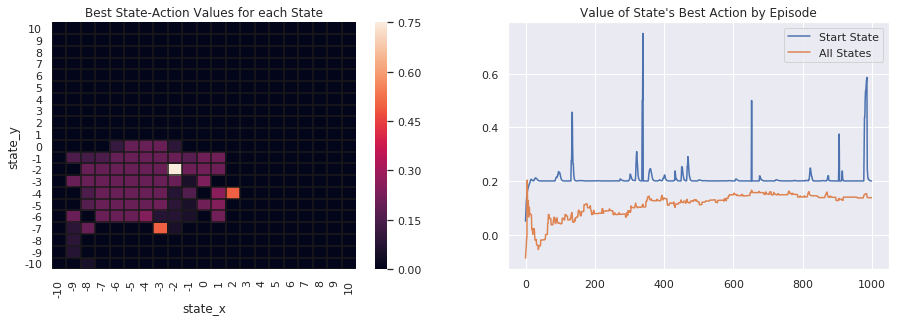

In [31]:
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Start State")
ax2.plot(best_actions_table[['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode")

plt.show()


**We improve this with a plot that shows the optimal action for each state as demonstrated in Part 1.**


In [32]:
optimal_action_start_state = best_actions_table[(best_actions_table['state_x']==start_x)&(best_actions_table['state_y']==start_y)].sort_values('episode',ascending=False)
if (optimal_action_start_state['throw_dir'].iloc[0]=="none"):
    print("The optimal action from the start state is to MOVE in direction: ", optimal_action_start_state['move_dir'].iloc[0])
else:
    print("The optimal action from the start state is to THROW in direction: ", optimal_action_start_state['throw_dir'].iloc[0])


The optimal action from the start state is to MOVE in direction:  1


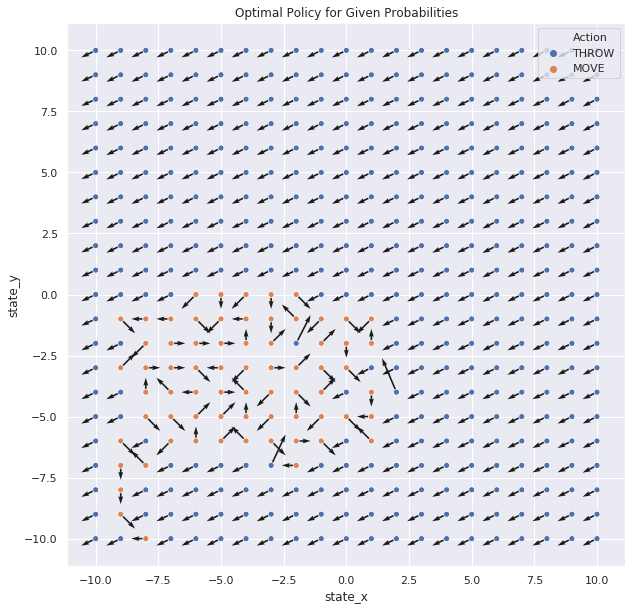

In [33]:
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

optimal_action_list = state_action_values

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))
                                             
# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))
                                             
x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values

plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Optimal Policy for Given Probabilities")
plt.show()

**We note that although we have a good result for the fixed start state, those around it that are also passed in episodes are less than optimal.**

As our goal is to learn for any given start state, we increase the range of start states to be considered for all between the [-10,10] range and pick randomly.

Current Episode:  99.9 %


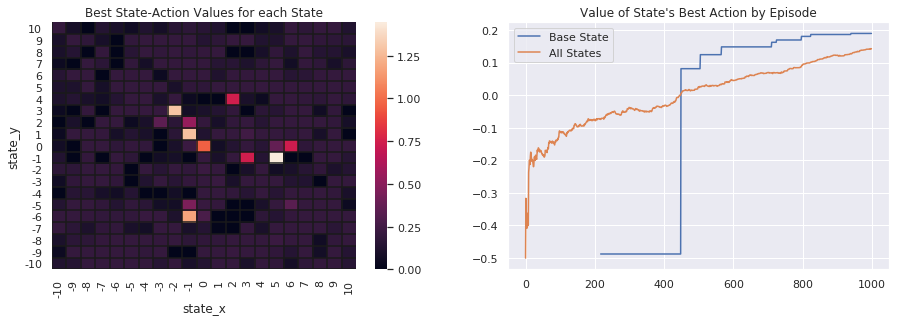

In [34]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.5
gamma = 0.5
V_bin = 0

num_episodes = 1000

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    
    # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
    start_x = np.random.randint(-10,11)
    start_y = np.random.randint(-10,11)
    
    
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Base State")
ax2.plot(best_actions_table[['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode")


plt.show()

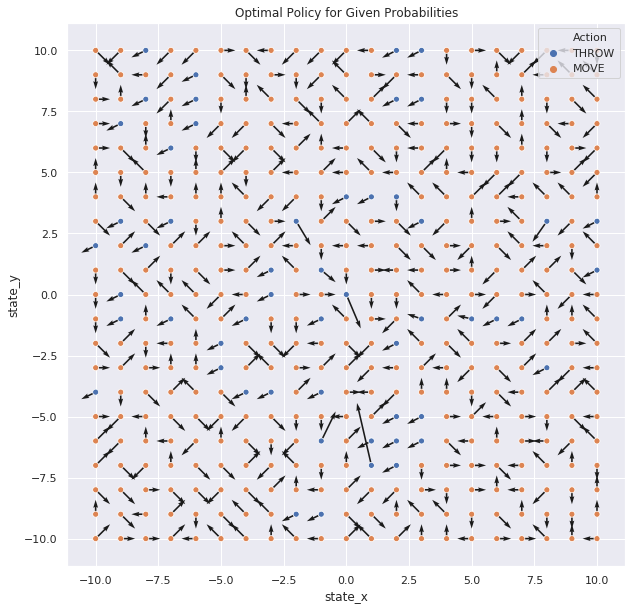

In [35]:
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

optimal_action_list = state_action_values

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))
                                             
# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))
                                             
x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values

plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Optimal Policy for Given Probabilities")
plt.show()

--- 

# Varying Parameters

We have three main parameters to vary, the learning rate $\alpha$, the discount factor $\gamma$ and our value for the $\epsilon-greedy$ action selection. 

The following explinations for each are taken directly from [Wikipedia](https://en.wikipedia.org/wiki/Q-learning) and have already introduced the $\epsilon$ parameter in some detail.


**Explore vs exploit**

*The learning rate or step size determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing (exclusively exploiting prior knowledge), while a factor of 1 makes the agent consider only the most recent information (ignoring prior knowledge to explore possibilities). In fully deterministic environments, a learning rate of $\alpha _{t}=1$ is optimal. When the problem is stochastic, the algorithm converges under some technical conditions on the learning rate that require it to decrease to zero. In practice, often a constant learning rate is used, such as $ \alpha _{t}=0.1$ for all $t$.[3]*

**Discount factor**

*The discount factor $\gamma$  determines the importance of future rewards. A factor of 0 will make the agent "myopic" (or short-sighted) by only considering current rewards, i.e. $r_{t}$ (in the update rule above), while a factor approaching 1 will make it strive for a long-term high reward. If the discount factor meets or exceeds 1, the action values may diverge. For $\gamma =1$, without a terminal state, or if the agent never reaches one, all environment histories become infinitely long, and utilities with additive, undiscounted rewards generally become infinite.[4] Even with a discount factor only slightly lower than 1, Q-function learning leads to propagation of errors and instabilities when the value function is approximated with an artificial neural network.[5] In that case, starting with a lower discount factor and increasing it towards its final value accelerates learning.[6]*


**So what do these mean, and, more importantly, what are we trying to achieve with our parameter selection?**

The overall aim is that we are trying to find the optimal action for any given state whilst achieving this in a reasonable number of effort (measured by the number of episodes, computation needed or time). A good explination for the **learning rate** is that a high value means we value the information gained in each action more and so learn faster but may find it hard to full converge whilst a small value will take longer but will steadily converge. 

A good analogy for this is to think of it like we are playing Golf with just one club; a high alpha corresponds to using a big-hitting club whilst a small alpha value is akin to using a small-hitting club. The big-hitting club will initially get us closer to the green but once we get close it is hard to accurately hit the hole. However, a small-hitting club will take more attempts to reach the green but once it does we have more control and can reach the hole easier.

![Alpha Analogy](https://i.imgur.com/ExGpRwl.png)

![Interactive Animation Example](https://i.imgur.com/qrpwvCi.gif)

We have already observed the effect of a large alpha parameter in our earlier applications where the values oscillated between each episode. Therefore, we need to use a small value but this introduces the challenge regarding the number of episodes required to converge. We already need thousands of episodes to converge for a fixed start state and we have 100 to consider for the full environment. 


**This is the trade-off we have to consider and the best decision may be to only learn for one fixed start state at a time when needed rather than trying to find the optimal policy for all states.**

When we observe the trends for varying alpha in the animation below, we see that, if we fix the start state, we are able to use a small alpha value without needing an impossibly large number of episodes. If we were to consider all states, we would likely need to use a slightly larger alpha value to reach a suitable result in good time.

**We therefore go back to considering a single fixed start state of [-5,-5] and choose an alpha value of $\alpha =  0.1$. **

**With these set, we then evaluate the choice of $\gamma$.** From the Wikipedia explination, we understand that the value corresponds to whether we consider furture rewards important or not. It helps when we consider this to remind ourselves of the update rule for Q-learning:

\begin{equation}
 Q^{new}(s_{t},a_{t})\leftarrow (1-\alpha )\cdot \underbrace {Q(s_{t},a_{t})} _{\text{old value}}+\underbrace {\alpha } _{\text{learning rate}}\cdot \overbrace {{\bigg (}\underbrace {r_{t}} _{\text{reward}}+\underbrace {\gamma } _{\text{discount factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\text{estimate of optimal future value}}{\bigg )}} ^{\text{learned value}}
 \end{equation}
 

With this, we see that $\gamma$ scales the Q value taken for the best action from the next state. This is in relation to the reward of the action itself as part of the same bracket and so if we reduce this by having a small gamma value then the reward has more weight. Conversely, if we take a high gamma value, we consider the imformation obtained from this next state to be more important.

**Therefore, we would ideally choose a value that adds value to future rewards so that our decisions lead to optimally to the bin and select a value of $\gamma = 0.9$.**







### Alpha Analysis

Current Episode:  99.0 %


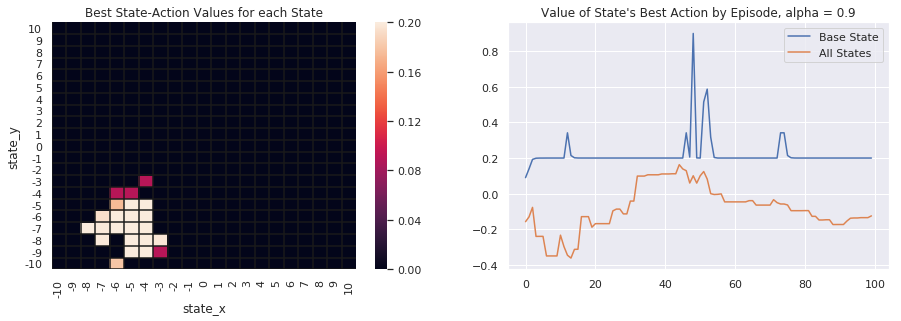

In [36]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.9
gamma = 0.5
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    
    # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
    start_x = -5
    start_y = -5
    
    
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Base State")
ax2.plot(best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode, alpha = 0.9")

plt.show()

Current Episode:  99.0 %


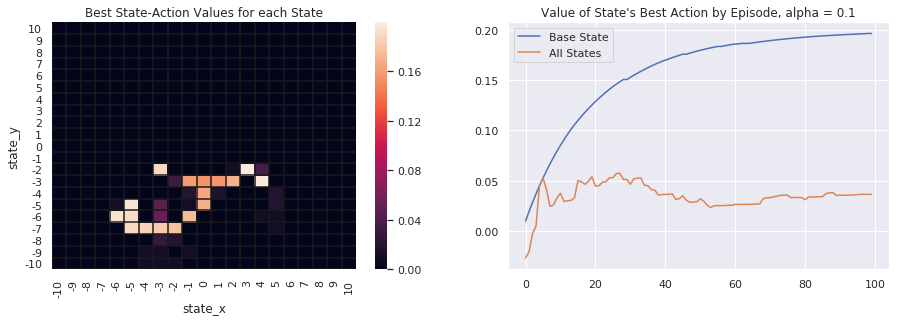

In [37]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.1
gamma = 0.5
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    
    # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
    start_x = -5
    start_y = -5
    
    
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Base State")
ax2.plot(best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode, alpha = 0.1")

plt.show()

In [38]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
gamma = 0.5
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()


best_actions_table = pd.DataFrame()
for alp in range(1,11):
    alpha = alp/10

    action_table = pd.DataFrame()
    for e in range(0,num_episodes):
        clear_output(wait=True)
        print("Current alpha: ", alpha)
        print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")

        # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
        start_x = -5
        start_y = -5


        action = None
        for a in range(0,action_cap):

            action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
            # If action is to throw, use probability to find whether this was successful or not and update accordingly
            if action['throw_dir'].iloc[0]!="none":
                rng_throw = np.random.rand()

                if rng_throw <= action['prob'].iloc[0]:
                    reward = 1
                else:
                    reward = -1
                bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
                bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
                New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
            # If move action, we have guaranteed probability and no introduce a small positive reward
            else:
                reward = 0.1
                move_direction = action['move_dir'].iloc[0]
                #Map this to actual direction and find V(s) for next state
                if(move_direction == 0):
                    move_x = 0
                    move_y = 1
                elif(move_direction == 1):
                    move_x = 1
                    move_y = 1
                elif(move_direction == 2):
                    move_x = 1
                    move_y = 0
                elif(move_direction == 3):
                    move_x = 1
                    move_y = -1
                elif(move_direction == 4):
                    move_x = 0
                    move_y = -1
                elif(move_direction == 5):
                    move_x = -1
                    move_y = -1
                elif(move_direction == 6):
                    move_x = -1
                    move_y = 0
                elif(move_direction == 7):
                    move_x = -1
                    move_y = 1

                new_x = action['state_x'].iloc[0]+move_x
                new_y = action['state_y'].iloc[0]+move_y
                next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
                next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']


                New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

            #Update Q(s,a) value for state based on outcome
            Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                        (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                        (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                        (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                        ),New_Q, Q_table_Q['Q'])

            #Add column to denote which episode this is for
            action['episode'] = e
            action_table = action_table.append(action)

            # Break loop if action is a throw
            if action['throw_dir'].iloc[0]!="none":
                break
            else:
                continue
        action_table = action_table.reset_index(drop=True)  

        #Find best states
        best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
        best_actions['episode'] = e
        best_actions['alpha'] = alpha

        best_actions_table = best_actions_table.append(best_actions)
    best_actions_table = best_actions_table.reset_index(drop=True)
    #Produce Summary output for each episode so we can observe convergence
    start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')

    state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])



Current alpha:  1.0
Current Episode:  99.0 %


In [39]:
best_actions_table.head(10)

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob,episode,alpha
0,none,4,-5,-5,0.010000,0,0,1.000000,0,0.1
1,208,none,-5,-6,-0.100000,0,0,0.000000,0,0.1
2,none,4,-5,-5,0.019000,0,0,1.000000,1,0.1
3,208,none,-5,-6,-0.100000,0,0,0.000000,1,0.1
4,none,4,-5,-5,0.027100,0,0,1.000000,2,0.1
5,155,none,-5,-6,-0.100000,0,0,0.000000,2,0.1
6,none,4,-5,-5,0.034390,0,0,1.000000,3,0.1
7,41,none,-5,-6,-0.100000,0,0,0.435848,3,0.1
8,none,4,-5,-5,0.040951,0,0,1.000000,4,0.1
9,41,none,-5,-6,-0.100000,0,0,0.435848,4,0.1


In [40]:
actions_plot_data = best_actions_table[best_actions_table['Q']!=0][['episode','alpha','Q']].groupby(['alpha','episode']).mean().reset_index()
actions_plot_data.head(10)

,alpha,episode,Q
0,0.1,0,-0.045000
1,0.1,1,-0.040500
2,0.1,2,-0.036450
3,0.1,3,-0.032805
4,0.1,4,-0.029525
5,0.1,5,-0.026572
6,0.1,6,0.070621
7,0.1,7,0.074253
8,0.1,8,0.064776
9,0.1,9,0.071174


In [41]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
import plotly.offline as py
py.init_notebook_mode(connected=True)


def InterAnim(Param_col, x_col, y_col, marker_size=None, plot_title=None, title_size=None, x_label=None,
              y_label=None, param_label=None, plot_type=None, marker_col=None, marker_alpha=None, fig_size_auto=None, fig_width=None, fig_height=None, vert_grid=None, horiz_grid=None ):

    # Need format: param(slider)/repeats(x)/output(y)
    ourData = pd.DataFrame()
    if (Param_col is None)|(x_col is None)|(y_col is None):
        print("Please provide data inputs: Parameter column, x column and y column.")
    else:
        ourData['year'] = Param_col
        ourData['lifeExp'] = x_col
        ourData['gdpPercap'] = y_col
    
    ourData['continent'] = ''
    ourData['country'] = ''
    
    
    # SET DEFAULT PARAMETERS
    if (marker_size is None):
        marker_size = 1
    else:
        marker_size = marker_size
    ourData['pop'] = 50000*marker_size

    # Find parameter intervals
    alpha = list(set(ourData['year']))
    alpha = np.round(alpha,1)
    alpha = np.sort(alpha)[::-1]
    years = np.round([(alpha) for alpha in alpha],1)

    
    if (plot_title is None):
        plot_title = ""
    else:
        plot_title = plot_title
    
    if (title_size is None):
        title_size = 24
    else:
        title_size = title_size
        
    if (x_label is None):
        x_label = ""
    else:
        x_label = x_label
        
    if (y_label is None):
        y_label = ""
    else:
        y_label = y_label

    if (param_label is None):
        param_label = ""
    else:
        param_label = param_label

    if (plot_type is None):
        plot_type = "markers"
    else:
        plot_type = plot_type    
        
    if (marker_col is None):
        marker_col = "rgb(66, 134, 244)"
    else:
        marker_col = marker_col    
    
    if (marker_alpha is None):
        marker_alpha = 0.8
    else:
        marker_alpha = marker_alpha 
        
    if (fig_size_auto is None):
        fig_size_auto = True
    else:
        fig_size_auto = fig_size_auto
        
    if (fig_size_auto  is  False) & (fig_width is None):
        fig_width = 1500
    else:
        fig_width = fig_width
        
    if (fig_size_auto  is  False) & (fig_height is None):
        fig_height = 1500
    else:
        fig_height = fig_height
        
    if (vert_grid is None):
        vert_grid = True
    else:
        vert_grid = vert_grid
    
    if (horiz_grid is None):
        horiz_grid = True
    else:
        horiz_grid = horiz_grid
        
        
    ## Apply Method for creating animation
    dataset = ourData
    continents = []
    for continent in dataset['continent']:
        if continent not in continents:
            continents.append(continent)
    # make figure
    figure = {
        'data': [],
        'layout': {},
        'frames': []
    }
    # fill in most of layout
    figure['layout']['title'] = {'text': plot_title, 'font':{'size':title_size}}
    figure['layout']['xaxis'] = {'range': [ min(dataset['lifeExp']) - (min(dataset['lifeExp'])/10),
                                            max(dataset['lifeExp']) + (max(dataset['lifeExp'])/10)  ], 'title': x_label, 'showgrid':vert_grid }
    figure['layout']['yaxis'] = {'range': [ min(dataset['gdpPercap']) - (min(dataset['gdpPercap'])/10),
                                            max(dataset['gdpPercap']) + (max(dataset['gdpPercap'])/10) ],'title': y_label, 'type': 'linear', 'showgrid':horiz_grid}
    figure['layout']['hovermode'] = 'closest'
    
    figure['layout']['autosize'] = fig_size_auto
    figure['layout']['width'] = fig_width
    figure['layout']['height'] = fig_height
    
    figure['layout']['sliders'] = {
        'args': [
            'transition', {
                'duration': 900,
                'easing': 'cubic-in-out'
            }
        ],
        'initialValue': '1952',
        'plotlycommand': 'animate',
        'values': years,
        'visible': True
    }
    figure['layout']['updatemenus'] = [
        {
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                    'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]


    sliders_dict = {
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': param_label,
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': []
    }
    # make data
    year = years[0]
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]
        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': plot_type,
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 100,
                'size': list(dataset_by_year_and_cont['pop'])
            },
            'name': continent
        }
        figure['data'].append(data_dict)
    # make frames
    for year in years:
        frame = {'data': [], 'name': str(year)}
        for continent in continents:
            dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
            dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]
            data_dict = {
                'x': list(dataset_by_year_and_cont['lifeExp']),
                'y': list(dataset_by_year_and_cont['gdpPercap']),
                'mode': plot_type,
                'text': list(dataset_by_year_and_cont['country']),
                'opacity':marker_alpha,
                'marker': {
                    'sizemode': 'area',
                    'sizeref': 100,
                    'size': list(dataset_by_year_and_cont['pop']),
                    'color':marker_col,
                },
                'name': continent
            }
            frame['data'].append(data_dict)
        figure['frames'].append(frame)
        slider_step = {'args': [
            [year],
            {'frame': {'duration': 700, 'redraw': False},
             'mode': 'immediate',
           'transition': {'duration': 700}}
         ],
         'label': year,
         'method': 'animate'}
        sliders_dict['steps'].append(slider_step)

    figure['layout']['sliders'] = [sliders_dict]
    
    return(figure)


In [42]:
Param_col = actions_plot_data['alpha']
x_col = actions_plot_data['episode']
y_col = actions_plot_data['Q']

marker_size = 0.7

plot_title = "Interactive-Animation Parameter Optimisation of RL Convergence - Varying Alpha"
title_size = 28
x_label = "Episode"
y_label = "Mean Q for all non-zero states"
param_label = "Alpha = "

#plot_type = 'markers', 'lines+markers' or 'lines'
plot_type = 'markers'

# color could also be hex code
marker_col = 'rgb(17, 157, 255)'
marker_alpha = 0.8

fig_size_auto = False
fig_width = 1500
fig_height = 700

# Gridlines
vert_grid = False
horiz_grid = True


In [43]:
animation_figure = InterAnim(
                            # REQUIRED
                            Param_col=Param_col, x_col=x_col, y_col=y_col,

                            # OPTIONAL AESTHETICS
                             marker_size=marker_size, plot_title=plot_title, title_size=title_size,
                             x_label=x_label, y_label=y_label, param_label=param_label, plot_type=plot_type,
                             marker_col=marker_col, marker_alpha=marker_alpha, fig_size_auto=fig_size_auto, 
                             fig_width=fig_width, fig_height=fig_height, vert_grid=vert_grid, horiz_grid=horiz_grid  )
iplot(animation_figure)


### Gamma Analysis

Current Episode:  99.0 %


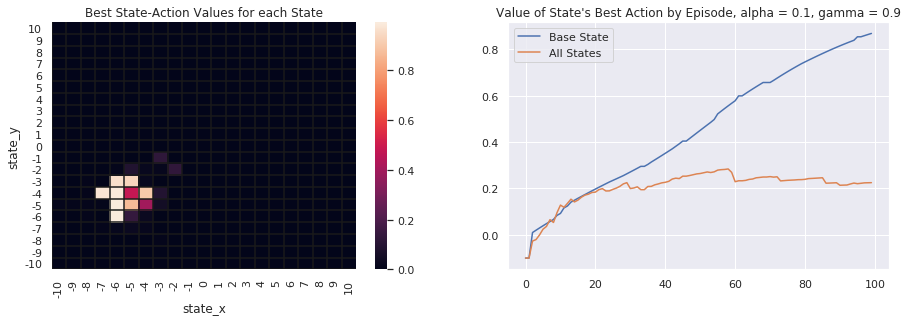

In [44]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.1
gamma = 0.9
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    
    # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
    start_x = -5
    start_y = -5
    
    
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Base State")
ax2.plot(best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode, alpha = 0.1, gamma = 0.9")

plt.show()

Current Episode:  99.0 %


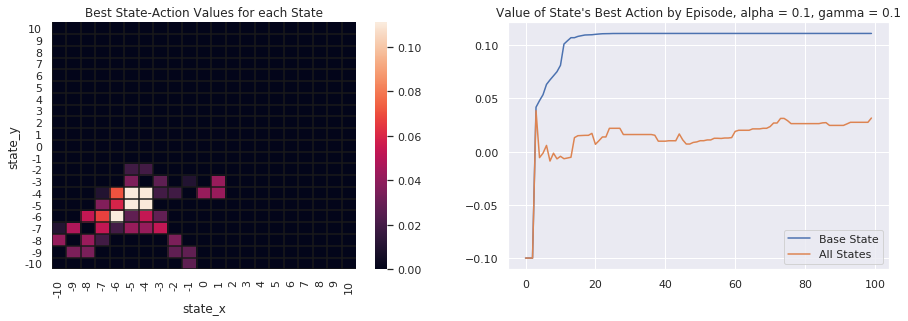

In [45]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.1
gamma = 0.1
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    
    # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
    start_x = -5
    start_y = -5
    
    
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Base State")
ax2.plot(best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode, alpha = 0.1, gamma = 0.1")

plt.show()

#### Interactive Animation for Gamma

In [46]:
#Change variable name to base for output graphs
base_x = -5
base_y = -5

bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.1
V_bin = 0

num_episodes = 100

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()


best_actions_table = pd.DataFrame()
for gam in range(1,11):
    gamma = gam/10

    action_table = pd.DataFrame()
    for e in range(0,num_episodes):
        clear_output(wait=True)
        print("Current alpha: ", alpha)
        print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")

        # Randomly select start position between: -4,-5,-6 (note the upper bound is soft, i.e. <-3 = <=-4)
        start_x = -5
        start_y = -5


        action = None
        for a in range(0,action_cap):

            action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
            # If action is to throw, use probability to find whether this was successful or not and update accordingly
            if action['throw_dir'].iloc[0]!="none":
                rng_throw = np.random.rand()

                if rng_throw <= action['prob'].iloc[0]:
                    reward = 1
                else:
                    reward = -1
                bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
                bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
                New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
            # If move action, we have guaranteed probability and no introduce a small positive reward
            else:
                reward = 0.1
                move_direction = action['move_dir'].iloc[0]
                #Map this to actual direction and find V(s) for next state
                if(move_direction == 0):
                    move_x = 0
                    move_y = 1
                elif(move_direction == 1):
                    move_x = 1
                    move_y = 1
                elif(move_direction == 2):
                    move_x = 1
                    move_y = 0
                elif(move_direction == 3):
                    move_x = 1
                    move_y = -1
                elif(move_direction == 4):
                    move_x = 0
                    move_y = -1
                elif(move_direction == 5):
                    move_x = -1
                    move_y = -1
                elif(move_direction == 6):
                    move_x = -1
                    move_y = 0
                elif(move_direction == 7):
                    move_x = -1
                    move_y = 1

                new_x = action['state_x'].iloc[0]+move_x
                new_y = action['state_y'].iloc[0]+move_y
                next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
                next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']


                New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

            #Update Q(s,a) value for state based on outcome
            Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                        (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                        (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                        (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                        ),New_Q, Q_table_Q['Q'])

            #Add column to denote which episode this is for
            action['episode'] = e
            action_table = action_table.append(action)

            # Break loop if action is a throw
            if action['throw_dir'].iloc[0]!="none":
                break
            else:
                continue
        action_table = action_table.reset_index(drop=True)  

        #Find best states
        best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
        best_actions['episode'] = e
        best_actions['gamma'] = gamma

        best_actions_table = best_actions_table.append(best_actions)
    best_actions_table = best_actions_table.reset_index(drop=True)
    #Produce Summary output for each episode so we can observe convergence
    start_state_action_values = best_actions_table[(best_actions_table['state_x']==base_x) & (best_actions_table['state_y']==base_y)][['episode','Q']].sort_values('episode')

    state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])



Current alpha:  0.1
Current Episode:  99.0 %


In [47]:
actions_plot_data = best_actions_table[best_actions_table['Q']!=0][['episode','gamma','Q']].groupby(['gamma','episode']).mean().reset_index()
actions_plot_data.head(10)

,gamma,episode,Q
0,0.1,0,-0.045000
1,0.1,1,-0.023667
2,0.1,2,-0.017933
3,0.1,3,0.006333
4,0.1,4,0.036333
5,0.1,5,0.063333
6,0.1,6,0.079573
7,0.1,7,0.047798
8,0.1,8,0.019200
9,0.1,9,0.018623


In [48]:
Param_col = actions_plot_data['gamma']
x_col = actions_plot_data['episode']
y_col = actions_plot_data['Q']

marker_size = 0.7

plot_title = "Interactive-Animation Parameter Optimisation of RL Convergence - Varying Gamma"
title_size = 28
x_label = "Episode"
y_label = "Mean Q for all non-zero states"
param_label = "Gamma = "

#plot_type = 'markers', 'lines+markers' or 'lines'
plot_type = 'markers'

# color could also be hex code
marker_col = 'rgb(204, 51, 255)'
marker_alpha = 0.8

fig_size_auto = False
fig_width = 1500
fig_height = 700

# Gridlines
vert_grid = False
horiz_grid = True


In [49]:
animation_figure = InterAnim(
                            # REQUIRED
                            Param_col=Param_col, x_col=x_col, y_col=y_col,

                            # OPTIONAL AESTHETICS
                             marker_size=marker_size, plot_title=plot_title, title_size=title_size,
                             x_label=x_label, y_label=y_label, param_label=param_label, plot_type=plot_type,
                             marker_col=marker_col, marker_alpha=marker_alpha, fig_size_auto=fig_size_auto, 
                             fig_width=fig_width, fig_height=fig_height, vert_grid=vert_grid, horiz_grid=horiz_grid  )
iplot(animation_figure)


## Final Parameter Output

    - alpha = 0.1
    - gamma = 0.9
    - epsilon = 0.1
    - 10,000 episodes
    - Fixed start state: [-5,-5]

In [50]:
# Define start position
start_x = -5
start_y = -5
bin_x = 0
bin_y = 0
action_cap = 10000

epsilon = 0.1
alpha = 0.1
gamma = 0.9
V_bin = 0

num_episodes = 10000

# Make a copy of the initalised Q table so we don't override this
Q_table_Q = Q_table.copy()

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%")
    action = None
    for a in range(0,action_cap):

        action = eps_greedy_Q(Q_table_Q, epsilon, start_x, start_y, a, action)
        # If action is to throw, use probability to find whether this was successful or not and update accordingly
        if action['throw_dir'].iloc[0]!="none":
            rng_throw = np.random.rand()

            if rng_throw <= action['prob'].iloc[0]:
                reward = 1
            else:
                reward = -1
            bin_Q = Q_table_Q[(Q_table_Q['state_x']==bin_x) & (Q_table_Q['state_y']==bin_y)]
            bin_max_Q = bin_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*bin_max_Q)) 
        # If move action, we have guaranteed probability and no introduce a small positive reward
        else:
            reward = 0.1
            move_direction = action['move_dir'].iloc[0]
            #Map this to actual direction and find V(s) for next state
            if(move_direction == 0):
                move_x = 0
                move_y = 1
            elif(move_direction == 1):
                move_x = 1
                move_y = 1
            elif(move_direction == 2):
                move_x = 1
                move_y = 0
            elif(move_direction == 3):
                move_x = 1
                move_y = -1
            elif(move_direction == 4):
                move_x = 0
                move_y = -1
            elif(move_direction == 5):
                move_x = -1
                move_y = -1
            elif(move_direction == 6):
                move_x = -1
                move_y = 0
            elif(move_direction == 7):
                move_x = -1
                move_y = 1

            new_x = action['state_x'].iloc[0]+move_x
            new_y = action['state_y'].iloc[0]+move_y
            next_action_Q = Q_table_Q[(Q_table_Q['state_x']==new_x) &  (Q_table_Q['state_y']==new_y)]
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
            

            New_Q = ((1-alpha)*action['Q'].iloc[0]) + alpha*(reward + (gamma*next_action_max_Q)) 

        #Update Q(s,a) value for state based on outcome
        Q_table_Q['Q'] = np.where( ((Q_table_Q['state_x'] == action['state_x'].iloc[0]) & 
                                    (Q_table_Q['state_y'] == action['state_y'].iloc[0]) &
                                    (Q_table_Q['throw_dir'] == action['throw_dir'].iloc[0]) &
                                    (Q_table_Q['move_dir'] == action['move_dir'].iloc[0])
                                    ),New_Q, Q_table_Q['Q'])
    
        #Add column to denote which episode this is for
        action['episode'] = e
        action_table = action_table.append(action)

        # Break loop if action is a throw
        if action['throw_dir'].iloc[0]!="none":
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  
    
    #Find best states
    best_actions = Q_table_Q[Q_table_Q['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
    best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==start_x) & (best_actions_table['state_y']==start_y)][['episode','Q']].sort_values('episode')
                                         
state_action_values = Q_table_Q.sort_values('Q',ascending=False).drop_duplicates(['state_x','state_y'])
    
    
sns.set(rc={'figure.figsize':(15,10)})
pivot = state_action_values[["state_y", "state_x", "Q"]].pivot("state_y", "state_x", "Q")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Best State-Action Values for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Start State")
ax2.plot(best_actions_table[['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States')
ax2.legend()
ax2.set_title("Value of State's Best Action by Episode")

plt.show()



Current Episode:  82.5 %


In [51]:

optimal_action_start_state = best_actions_table[(best_actions_table['state_x']==start_x)&(best_actions_table['state_y']==start_y)].sort_values('episode',ascending=False)
if (optimal_action_start_state['throw_dir'].iloc[0]=="none"):
    print("The optimal action from the start state is to MOVE in direction: ", optimal_action_start_state['move_dir'].iloc[0])
else:
    print("The optimal action from the start state is to THROW in direction: ", optimal_action_start_state['throw_dir'].iloc[0])



The optimal action from the start state is to MOVE in direction:  2


In [52]:
optimal_action_start_state.head()

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob,episode
1136612,none,2,-5,-5,1.0,0,0,1.0,9999
1136467,none,2,-5,-5,1.0,0,0,1.0,9998
1136322,none,2,-5,-5,1.0,0,0,1.0,9997
1136188,none,2,-5,-5,1.0,0,0,1.0,9996
1136032,none,2,-5,-5,1.0,0,0,1.0,9995


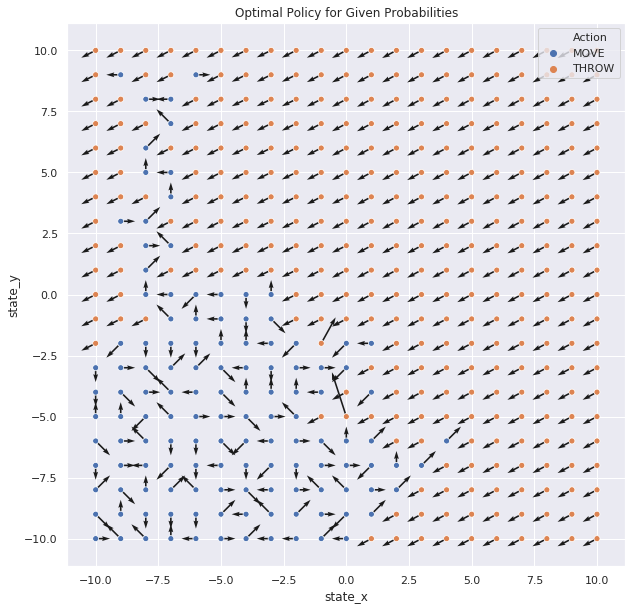

In [53]:
    
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

optimal_action_list = state_action_values

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))
                                             
# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))
                                             
x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values

plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Optimal Policy for Given Probabilities")
plt.show()

# Conclusion

We see that the final output for start state is to move south east. As mentioned, we may want to consider changing the rewards so that throwing is more encouraged than moving. The results for all states covered by the episodes converge within the 10,000 episodes though it appears that many have yet to be fully explored and are not optimal. But if we only concered with the start state then these do not matter significantly.

I hope this notebook is useful for demonstrating the impact each parameter has on learning and the overall process of RL in a self contained example.

Thanks

